# MultiModal RAG!

ChromaDB's [recent announcement](https://docs.trychroma.com/guides/multimodal) of integration with CLIP embeddings

![x](clip.drawio.png)

## Dependencies

In [ ]:
!pip install chromadb openai datasets langchain IPython langchain-openai open-clip-torch

In [2]:
import os
import chromadb
import base64
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from IPython.display import Image, display, Markdown
from datasets import load_dataset
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

## Loading the Dataset

Going to be using the [Fashionpedia dataset](https://huggingface.co/datasets/detection-datasets/fashionpedia) through HuggingFace, originally created as an object detection training dataset.

In [3]:
dataset = load_dataset("detection-datasets/fashionpedia")

README.md:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

e:\Anaconda\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\svaru\.cache\huggingface\hub\datasets--detection-datasets--fashionpedia. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


dataset_infos.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

#### Sample Image

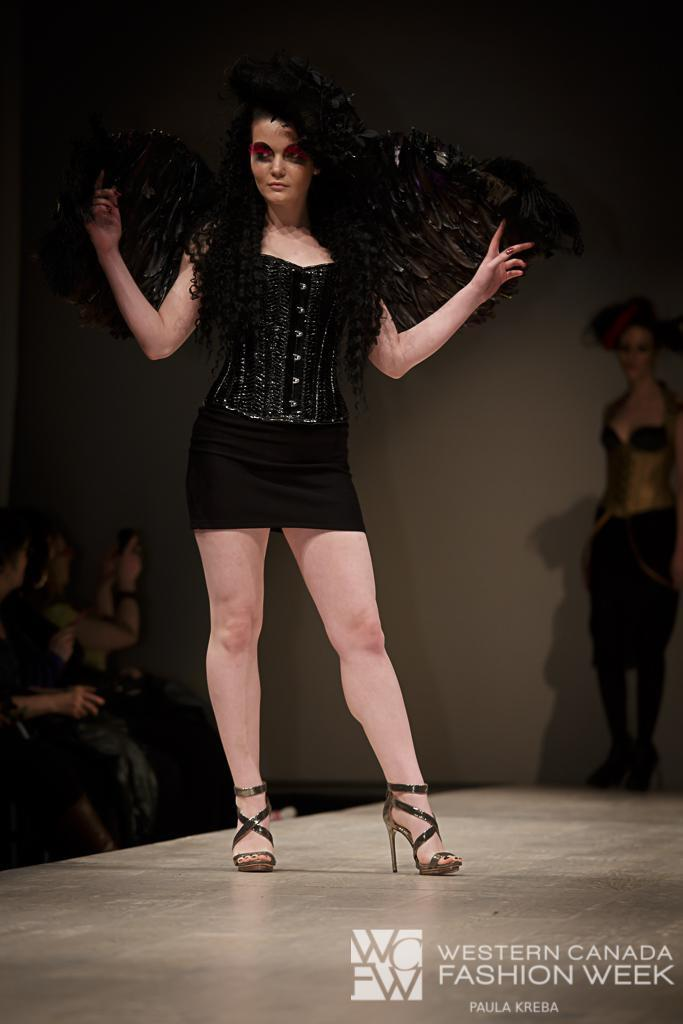

In [4]:
dataset['train'][100]['image']

For this example, only the first 1000 photos were taken and saved locally to make it easier to load into the Vector Database

In [5]:
# Define the folder to save the images
dataset_folder = 'image_rag/fashion_dataset'
os.makedirs(dataset_folder, exist_ok=True)

# Function to save images
def save_images(dataset, dataset_folder, num_images=1000):
    for i in range(num_images):
        # Get the image data
        image = dataset['train'][i]['image']

        # Save the image
        image.save(os.path.join(dataset_folder, f'image_{i+1}.png'))

# Save the first 1000 images
save_images(dataset, dataset_folder, num_images=1000)

print(f"Saved the first 1000 images to {dataset_folder}")

Saved the first 1000 images to image_rag/fashion_dataset


# Setting Up the Vector Database

Open-source vector database [ChromaDB](https://www.trychroma.com/), which recently announced its support for multimodal embeddings is used in this project. ChromaDB's OpenCLIP integration currently uses the [CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K) embedding model. A CLIP ViT-B/32 model trained with the LAION-2B English subset of [LAION-5B](https://laion.ai/blog/laion-5b/) using [OpenCLIP](https://github.com/mlfoundations/open_clip).

In [7]:
# Instantiate the ChromaDB CLient
chroma_client = chromadb.PersistentClient(path="E:\Projects\multimodal-rag-main\image_vdb")
# Instantiate the ChromaDB Image Loader
image_loader = ImageLoader()
# Instantiate CLIP embeddings
CLIP = OpenCLIPEmbeddingFunction()

# Create the image vector database
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function = CLIP, data_loader = image_loader)

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\svaru\AppData\Local\Temp\ipykernel_2676\1476356514.py:2: SyntaxWarning: invalid escape sequence '\P'
  chroma_client = chromadb.PersistentClient(path="E:\Projects\multimodal-rag-main\image_vdb")


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

e:\Anaconda\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\svaru\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


### Adding Images into the VectorDB

In [8]:
# Initialize lists for ids and uris (uniform resource identifiers, which in this case is just the path to the image)
ids = []
uris = []

# Iterate over each file in the dataset folder
for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
    if filename.endswith('.png'):
        file_path = os.path.join(dataset_folder, filename)

        # Append id and uri to respective lists
        ids.append(str(i))
        uris.append(file_path)

# Assuming multimodal_db is already defined and available
image_vdb.add(
    ids=ids,
    uris=uris
)

print("Images added to the database.")


Images added to the database.


In [9]:
# Validate the VectorDB with .count()
image_vdb.count()

1000

### Querying the VectorDB

ID: 306
Distance: 1.411705732345581
Path: image_rag/fashion_dataset\image_374.png


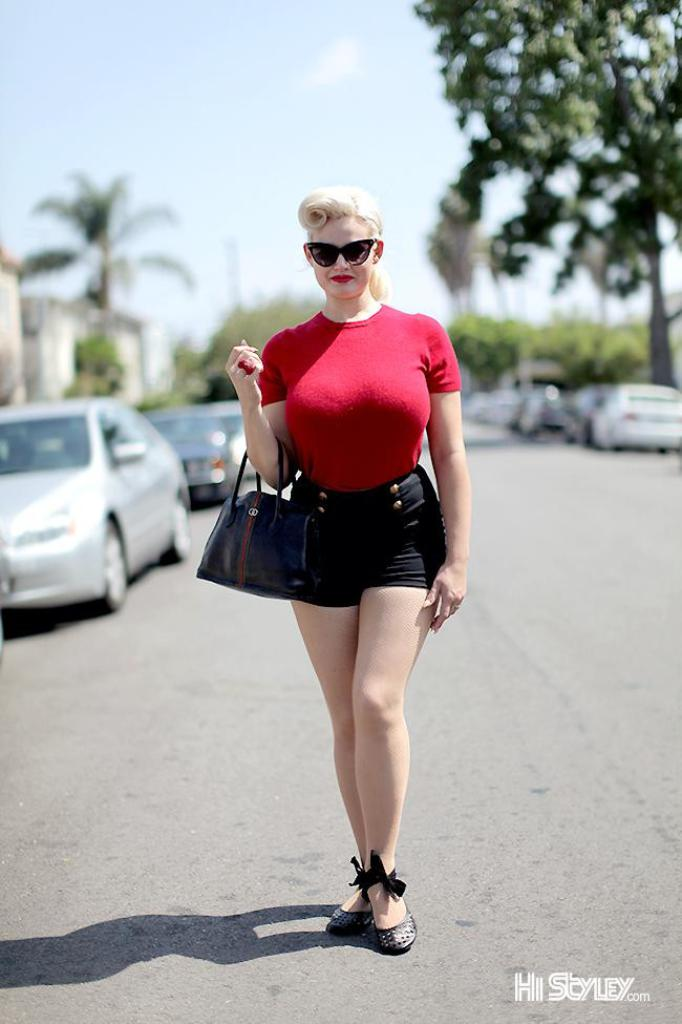



ID: 680
Distance: 1.4652882814407349
Path: image_rag/fashion_dataset\image_710.png


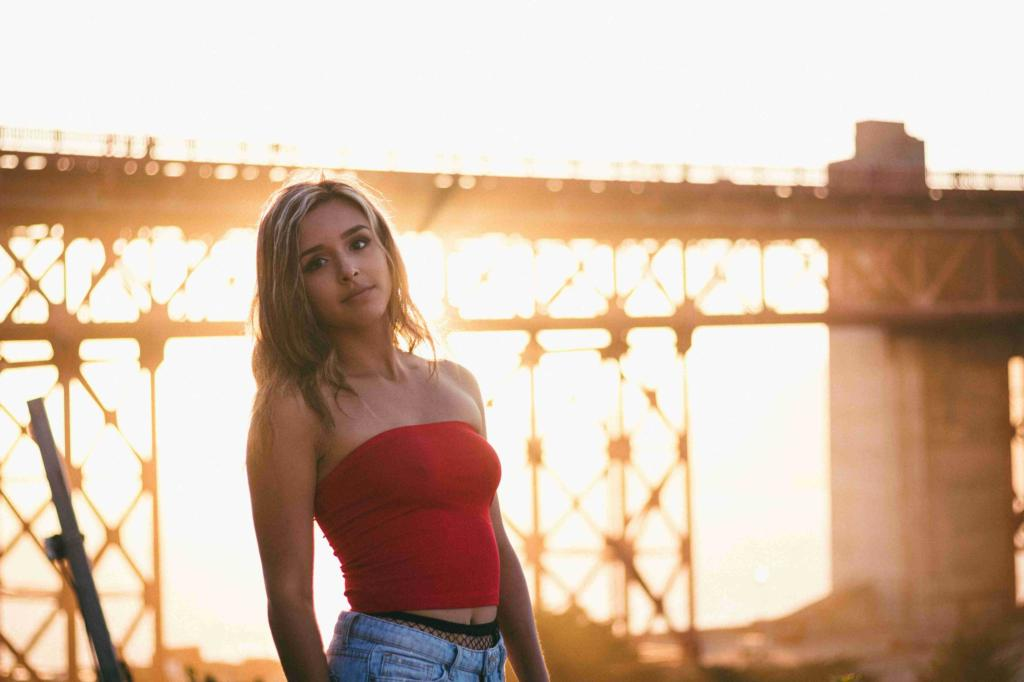



ID: 112
Distance: 1.4668556451797485
Path: image_rag/fashion_dataset\image_2.png


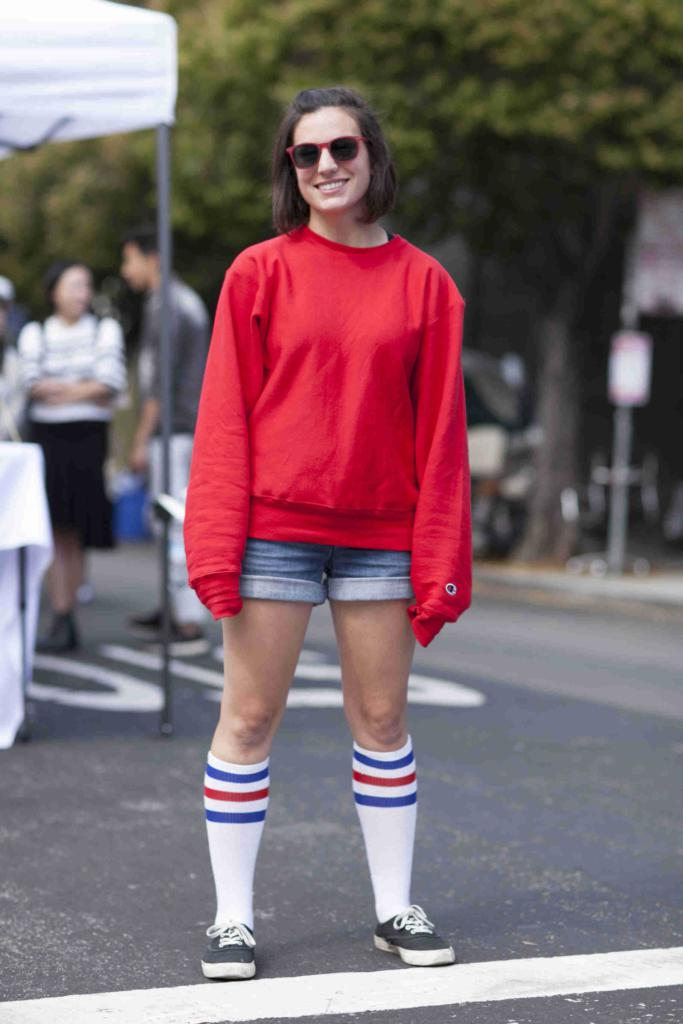

In [10]:
def query_db(query, results=3):
    results = image_vdb.query(
        query_texts=[query],
        n_results=results,
        include=['uris', 'distances'])
    return results

def print_results(results):
    for idx, uri in enumerate(results['uris'][0]):
        print(f"ID: {results['ids'][0][idx]}")
        print(f"Distance: {results['distances'][0][idx]}")
        print(f"Path: {uri}")
        display(Image(filename=uri, width=300))
        print("\n")

# Testing it out
query = 'red tops'
results = query_db(query)
print_results(results)

### Defining the LLM, Prompt, and LangChain Chain

In [11]:
# Instantiate the LLM
gpt4o = ChatOpenAI(model="gpt-4o", temperature = 0.0, api_key="")

# Instantiate the Output Parser
parser = StrOutputParser()

# Define the Prompt
image_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful fashion and styling assistant. Answer the user's question  using the given image context with direct references to parts of the images provided."
                    " Maintain a more conversational tone, don't make too many lists. Use markdown formatting for highlights, emphasis, and structure."),
        (
            "user",
            [
                {"type": "text", "text": "What are some ideas for styling {user_query}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_1}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_2}"},
            ],
        ),
    ]
)

# Define the LangChain Chain
vision_chain = image_prompt | gpt4o | parser

### Formatting Query Results for LLM Prompting

To input the images in as context, they are first encoded to [base64](https://en.wikipedia.org/wiki/Base64) for the LLM to be able to interpret it.

In [12]:
def format_prompt_inputs(data, user_query):
    inputs = {}

    # Add user query to the dictionary
    inputs['user_query'] = user_query

    # Get the first two image paths from the 'uris' list
    image_path_1 = data['uris'][0][0]
    image_path_2 = data['uris'][0][1]

    # Encode the first image
    with open(image_path_1, 'rb') as image_file:
        image_data_1 = image_file.read()
    inputs['image_data_1'] = base64.b64encode(image_data_1).decode('utf-8')

    # Encode the second image
    with open(image_path_2, 'rb') as image_file:
        image_data_2 = image_file.read()
    inputs['image_data_2'] = base64.b64encode(image_data_2).decode('utf-8')

    return inputs

The output of this will look like this

```python
{
    "user_query": "What are some ideas for styling X"
    "image_data_1": Base64 Encoding of Image 1
    "image_data_2": Base64 Encoding of Image 2
}
```

And get passed to the prompt before all going to the language model

## FashionRAG

What would you like to style today?

---

**Example Picture 1:**

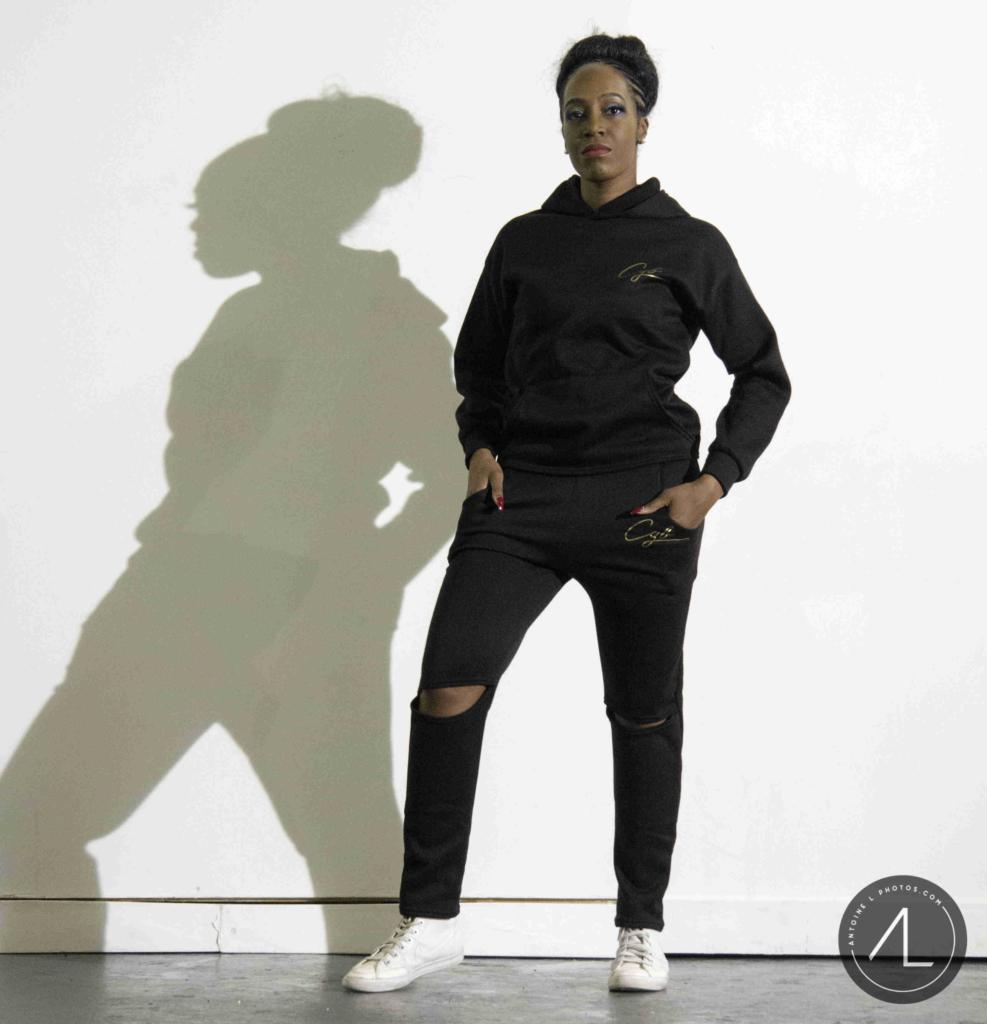

**Example Picture 2:**

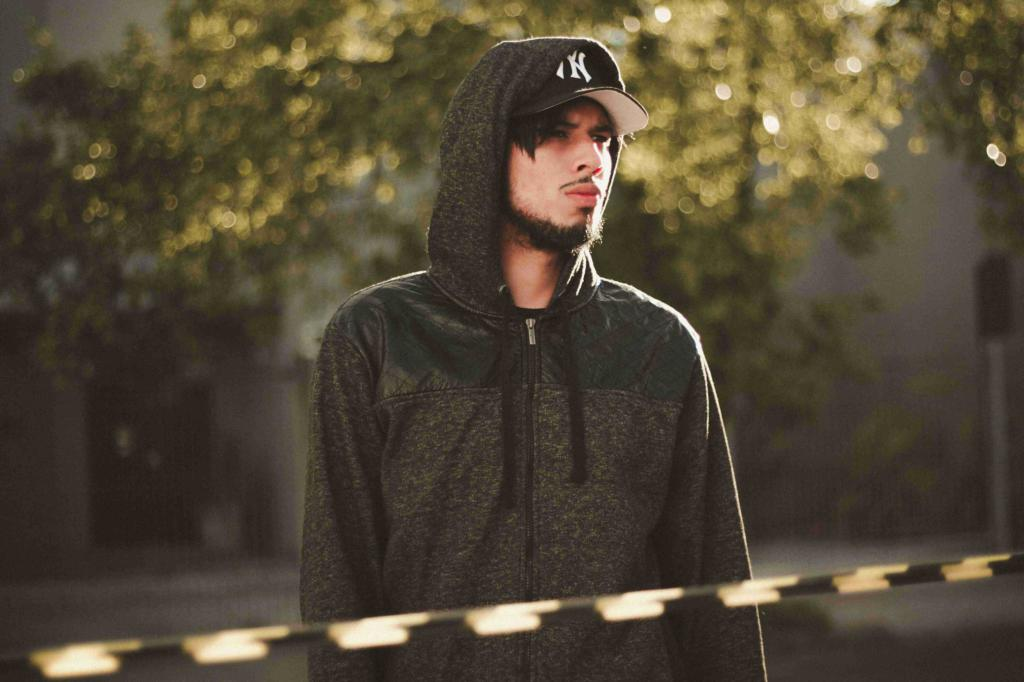

---

Styling a hoodie can be both fun and versatile! Here are some ideas inspired by the images:

1. **Casual Chic**: 
   - Pair your hoodie with ripped jeans or joggers, like in the first image. This gives a relaxed yet stylish vibe.
   - Add white sneakers for a clean, classic look.

2. **Layered Look**:
   - In the second image, the hoodie is paired with a cap, which adds a sporty touch. You can layer a denim or leather jacket over the hoodie for extra style and warmth.

3. **Accessorize**:
   - Add a beanie or a baseball cap for a laid-back, cool look.
   - Consider a crossbody bag or a backpack to keep it practical and trendy.

4. **Street Style**:
   - Mix and match with different textures, like pairing a hoodie with leather pants or a skirt.
   - Add statement sneakers or boots to elevate the outfit.

5. **Monochrome Magic**:
   - Stick to one color palette for a sleek, modern look. The all-black ensemble in the first image is a great example.

6. **Sporty Vibes**:
   - Wear your hoodie with athletic shorts or leggings for a sporty, on-the-go outfit.

Experiment with these ideas to find what suits your style best!

In [15]:
display(Markdown("## FashionRAG"))
display(Markdown("What would you like to style today?"))

query = input("\n")

# Running Retrieval and Generation
results = query_db(query, results=2)
prompt_input = format_prompt_inputs(results, query)
response = vision_chain.invoke(prompt_input)

display(Markdown("---"))
# Showing Retrieved Pictures
display(Markdown("**Example Picture 1:**"))
display(Image(filename=results['uris'][0][0], width=300))
display(Markdown("**Example Picture 2:**"))
display(Image(filename=results['uris'][0][1], width=300))

display(Markdown("---"))
# Printing LLM Response
display(Markdown(response))